In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


# Adaptive determination of Monte Carlo trials

The Monte Carlo outcome is based on **random** draws from the joint probability distribution associated with the input quantities. Thus, the outcome and every statistics derived are **random**.

### Exercise 5.1

For the model function 
$$ Y = f(X_1,X_2,X_3) = X_1 + X_2 + X_3 $$
with independent input quantities for which knowledge is encoded as

- $X_1$: Gamma distribution with scale parameter $a=1.5$

- $X_2$: normal distribution with $\mu=1.3$ and $\sigma=0.1$

- $X_3$: t-distribution with location parameter $0.8$ and scale parameter $0.3$ and with 5 degrees of freedom

carry out a Monte Carlo simulation with 1000 runs. Repeat this simulation 100 times using a for-loop. Calculate and store the estimates $y$ for each simulation run and compare the different outcomes.

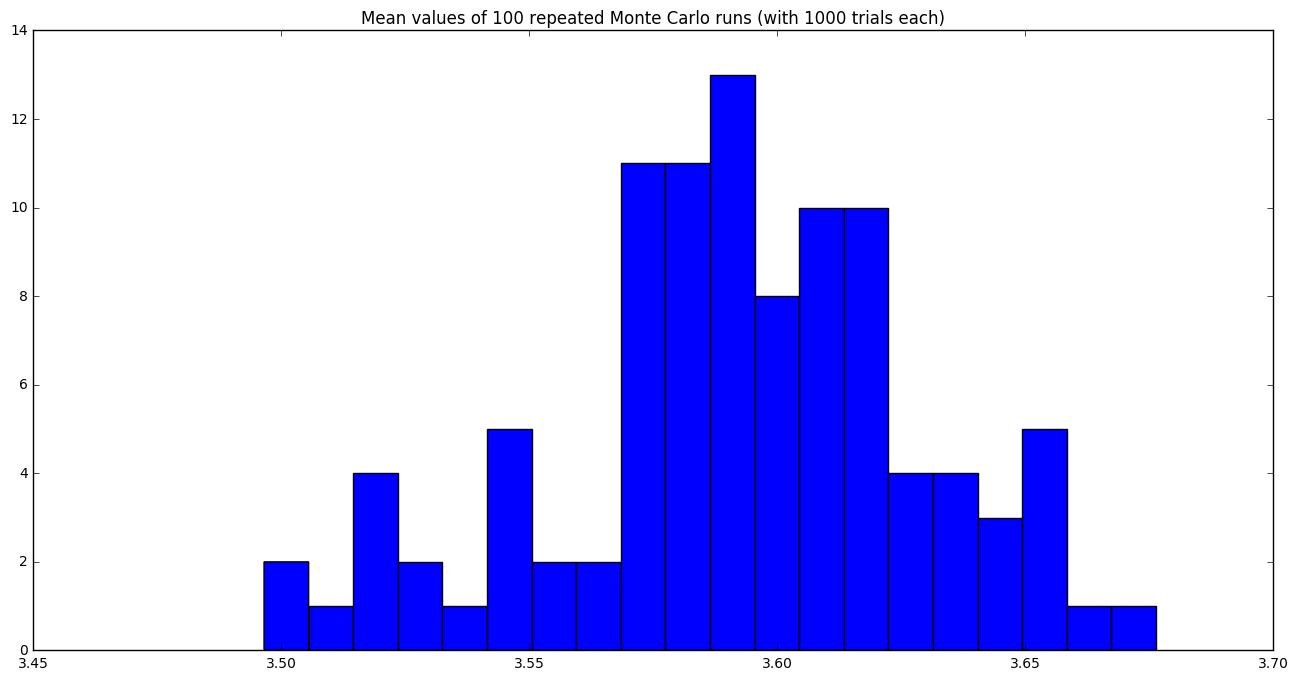

In [2]:
from scipy.stats import gamma, norm, t

rst = random.RandomState(1)

# distribution of input quantities
x1dist = gamma(1.5)
x2dist = norm(loc=1.3, scale=0.1)
x3dist = t(loc=0.8, scale=0.3, df=5)

# measurement model
model = lambda X1,X2,X3: X1 + X2 + X3

MCruns = 1000
repeats= 100

means = zeros(repeats)

# repeat Monte Carlo runs
for k in range(repeats):
    x1 = x1dist.rvs(MCruns)
    x2 = x2dist.rvs(MCruns)
    x3 = x3dist.rvs(MCruns)
    Y = model(x1,x2,x3)
    means[k] = Y.mean()

hist(means, bins = 20)
title("Mean values of 100 repeated Monte Carlo runs (with 1000 trials each)");

## Adaptive Monte Carlo method

The randomness of the Monte Carlo outcomes cannot be avoided. However, the variation between runs decreases with an increasing number of Monte Carlo simulations. The aim is thus to adaptively decide on the number of Monte Carlo trials based on

* a prescribed numerical tolerance

* at a chosen level of confidence

#### Stein's method

From Wübbeler et al. (doi: http://iopscience.iop.org/0026-1394/47/3/023):

Let $y_1, y_2, \ldots$ be a sequence of values drawn independentyl from a Gaussian distribution with unknown expecation $\mu$ and variance $\sigma^2$. 
The aim is to determine a rule that terminates this sequence such that $\bar{y}(h)$, being the average of the sequence terminated at $h$, satisfies that the interval
$$ [\bar{y}(h)-\delta, \bar{y}(h)+\delta] $$
is a confidence interval for $\mu$ at confidence level $1-\alpha$.

1) Draw an initial number $h_1>1$ of samples and calculate
$$ s_y^2(h_1) = \frac{1}{h-1} \sum_{i=1}^{h_1} (y_i - \bar{y}(h_1))^2 $$

2) Calculate the number $h_2$ of additional values as
$$ h_2 = \max \left( floor({\frac{s_y^2(h_1)(t_{h_1-1,1-\alpha/2})^2}{\delta^2}})-h_1+1,0 \right) $$

#### Application to Monte Carlo simulations

We consider Monte Carlo simulations block-wise. That is, we choose a modest number of Monte Carlo trials, e.g. 1000, and consider a Monte Carlo simulation with that number of trials as one block. Each block has a block mean, standard deviation (uncertainty), etc. 

With $h_1$ being the number of such blocks and $y_1,y_2,\ldots$ a selected outcome of each block (e.g. the mean, variance, interval boundaries, etc.) Stein's method can be applied to calculate the additionally required number of blocks.

**Reminder**
The deviation $\delta$ can be calculated from a prescribed number of significant digits as follows:

- Write the number of interest in the form $ z = c \times 10^l$ with $c$ having the chosen number of digits.

- Calculate the numerical tolerance as $\delta = \frac{1}{2} 10^l$

### Exercise 5.2

Repeat Exercise 5.1 using Stein's method, starting with an initial number of $h_1 = 10$ repetitions. Calculate $h_2$ such that a numerical tolerance of 2 digits is achieved with a 95% level of confidence. 

In [3]:
from scipy.stats import gamma, norm, t
rst = random.RandomState(1)

# distributions of input quantities
x1dist = gamma(1.5)
x2dist = norm(loc=1.3, scale=0.1)
x3dist = t(loc=0.8, scale=0.3, df=5)

# measurement model
model = lambda X1,X2,X3: X1 + X2 + X3

# Monte Carlo block size
MCruns = 1000
# number of initial Monte Carlo blocks
h1 = 10

means = zeros(h1)
delta = 0.05
alpha = 0.05

# repeated Monte Carlo method
for k in range(h1):
    x1 = x1dist.rvs(MCruns)
    x2 = x2dist.rvs(MCruns)
    x3 = x3dist.rvs(MCruns)
    Y = model(x1,x2,x3)
    means[k] = Y.mean()

In [4]:
# calculate additional number of Monte Carlo blocks
h2 = int(max( floor(means.var()*t(h1-1).ppf(1-alpha/2)**2/delta**2) - h1+1, 0 ))

means = np.r_[means, zeros(h2)]

# repeated Monte Carlo method
for k in range(h1,h1+h2):
    x1 = x1dist.rvs(MCruns)
    x2 = x2dist.rvs(MCruns)
    x3 = x3dist.rvs(MCruns)
    Y = model(x1,x2,x3)
    means[k] = Y.mean()
    
y = means.mean()
    
print(y)

3.58152858849


The confidence level for the achieved accuracy is a frequentist measure. Therefore, in order to verify the achieved confidence, we repeat the adaptive Monte Carlo method and assess the long run success.

In [5]:
# validate the level of confidence
reruns = 1000

y = zeros(reruns)

MCruns = 1000
h1 = 10

for r in range(reruns):

    means = zeros(h1)
    delta = 0.05
    alpha = 0.05

    for k in range(h1):
        x1 = x1dist.rvs(MCruns)
        x2 = x2dist.rvs(MCruns)
        x3 = x3dist.rvs(MCruns)
        Y = model(x1,x2,x3)
        means[k] = Y.mean()

    h2 = int(max( floor(means.var()*t(h1-1).ppf(1-alpha/2)**2/delta**2) - h1+1, 0 ))

    means = np.r_[means, zeros(h2)]
    for k in range(h1,h1+h2):
        x1 = x1dist.rvs(MCruns)
        x2 = x2dist.rvs(MCruns)
        x3 = x3dist.rvs(MCruns)
        Y = model(x1,x2,x3)
        means[k] = Y.mean()
        
    y[r] = means.mean()


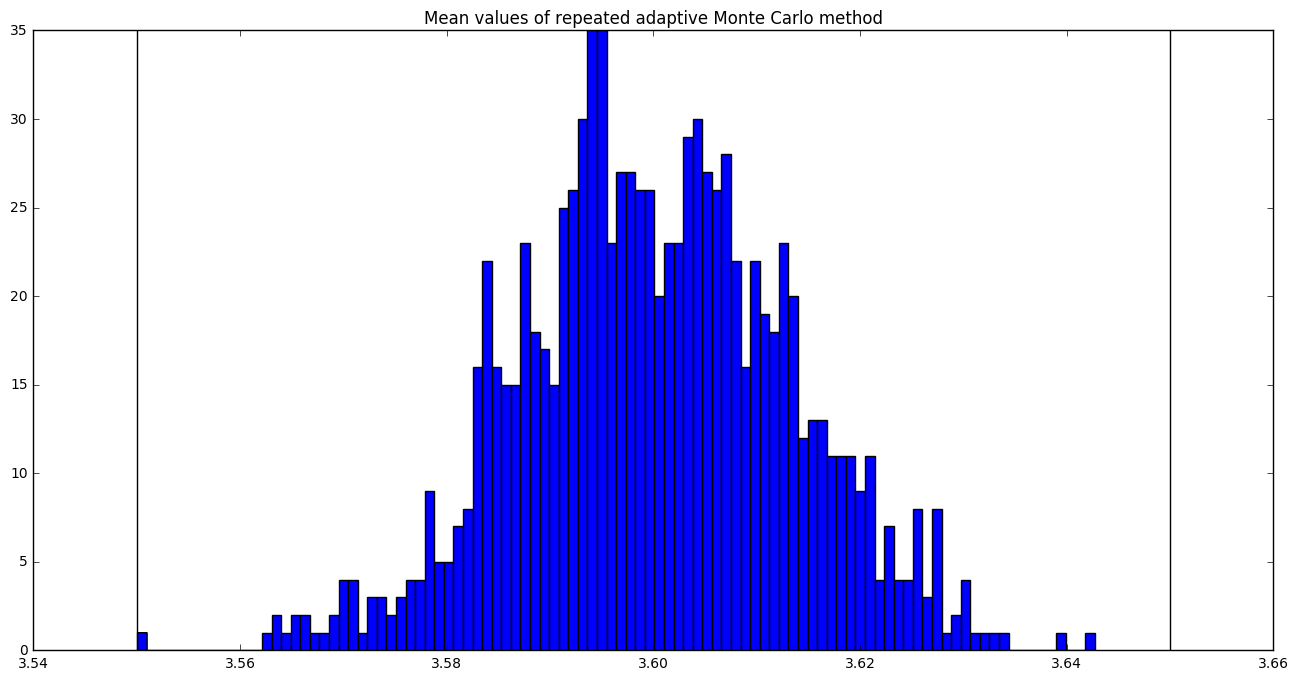

In [6]:
hist(y, bins = 100)
axvline(y.mean()-delta, color="k")
axvline(y.mean()+delta, color="k")
title("Mean values of repeated adaptive Monte Carlo method");

The results of the adaptive Monte Carlo method are still random. The spread of calculated mean values, however, is below the chosen tolerance with the prescribed level of confidence.